# EDA and Data Preprocessing on SODA

by Ding


The SODA 3.3.1 is retrieved from [ERDDAP](https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdSoda331oceanmday.html), with the following dimensions and variables selected.

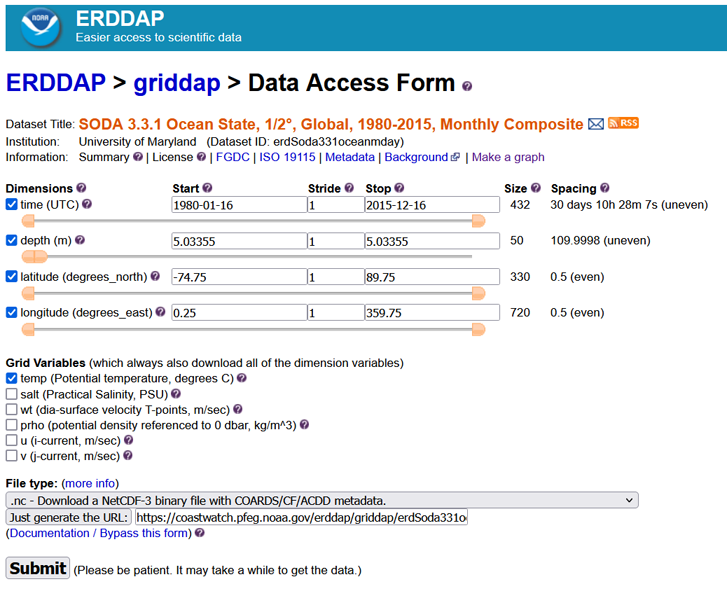

Import the libraries.

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.1 MB/s 
     |████████████████████████████████| 15.4 MB 50.7 MB/s 
     |████████████████████████████████| 6.3 MB 49.1 MB/s 


In [2]:
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

Connect Google Drive with Google Colab.

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive



Move the dataset to the default working directory.

In [4]:
%%bash
cp -a '/gdrive/MyDrive/soda_331_pt_l5.nc' '/content/'
cp -a '/gdrive/MyDrive/sst_anomaly.nc' '/content/'

Display the data.

In [5]:
soda = xr.open_dataset('soda_331_pt_l5.nc', decode_times=False)
soda

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 330, longitude: 720, time: 432)
Coordinates:
  * time       (time) float64 3.168e+08 3.195e+08 ... 1.448e+09 1.45e+09
  * depth      (depth) float32 5.034
  * latitude   (latitude) float32 -74.75 -74.25 -73.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Data variables:
    temp       (time, depth, latitude, longitude) float32 ...
Attributes: (12/47)
    _CoordSysBuilder:              ucar.nc2.internal.dataset.conv.DefaultConv...
    acknowledgement:               The SODA3 project is funded by the US Nati...
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    Created_by:                    Gennady Chepurin and Ligang Chen
    creation_date:                 October, 2016
    ...                            ...
    summary:                       SODA3.3.1 ocean state, forced by MERRA2. T...
    time_coverage_end:             2015-12-16T00:00:00Z
    time_coverage_start:           1980-01-16T00:00:00Z
    title:                         SODA 3.3.1 Ocean State, 1/2°, Global, 1980...
    Website:                       https://www.atmos.umd.edu/~ocean/
    Westernmost_Easting:           0.25

Since we are interested in the global warmming hotpots in Figure 1 of [Frölicher & Laufkötter, 2018](https://www.nature.com/articles/s41467-018-03163-6), we need the coordinates of these locations.

We are thinking about using computer vision to obtain the coorindates from the image.

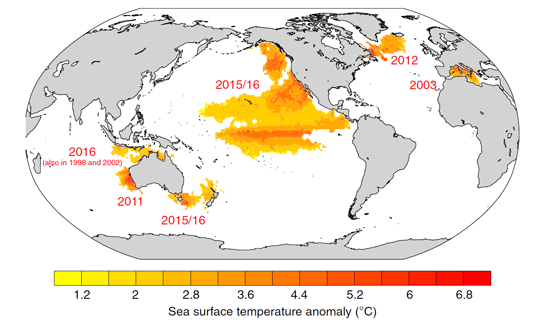

Fortunatelly, specially thank Prof. Thomas Frölicher, the first author and corresponding author of [Frölicher & Laufkötter, 2018](https://www.nature.com/articles/s41467-018-03163-6), who kindly shared the coordinates with us. The shared file contains the data from Figure 1a of [Le Grix et al. 2021](https://bg.copernicus.org/articles/18/2119/2021/bg-18-2119-2021.html), which shows an updated figure of the Figure 1 of [Frölicher & Laufkötter, 2018](https://www.nature.com/articles/s41467-018-03163-6) and is based on [Laufkötter et al., 2020](https://www.science.org/doi/full/10.1126/science.aba0690).

Explore the coordinates.

In [6]:
anomalies = xr.open_dataset('sst_anomaly.nc', decode_times=False)
anomalies

<xarray.Dataset>
Dimensions:  (lat: 234, lon: 288)
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -84.0 -83.33 -82.67 -82.0 ... 69.33 70.0 70.67 71.33
Data variables:
    sst      (lat, lon) float64 ...

In [7]:
df_anomalies_coordinates = anomalies.to_dataframe()
df_anomalies_coordinates = df_anomalies_coordinates.reset_index()

In [8]:
df_anomalies_coordinates.head()

,lat,lon,sst
0,-84.0,-180.00,NaN
1,-84.0,-178.75,NaN
2,-84.0,-177.50,NaN
3,-84.0,-176.25,NaN
4,-84.0,-175.00,NaN


In [9]:
df_anomalies_coordinates.count()

lat    67392
lon    67392
sst     8835
dtype: int64

In [10]:
df_anomalies_coordinates_nona = df_anomalies_coordinates.dropna()

In [11]:
df_anomalies_coordinates_nona.head()

,lat,lon,sst
5590,-71.333333,-32.50,0.880000
5591,-71.333333,-31.25,1.104444
5592,-71.333333,-30.00,1.298333
5877,-70.666666,-33.75,1.080000
5878,-70.666666,-32.50,1.393333


In [12]:
df_anomalies_coordinates_nona.count()

lat    8835
lon    8835
sst    8835
dtype: int64

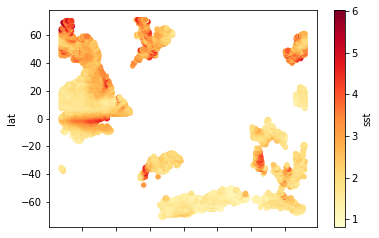

In [13]:
df_anomalies_coordinates_nona.plot(x="lon", y="lat", kind="scatter", c="sst", colormap="YlOrRd")

In [14]:
geometry = [Point(xy) for xy in zip(df_anomalies_coordinates_nona['lon'], df_anomalies_coordinates_nona['lat'])]
gdf = GeoDataFrame(df_anomalies_coordinates_nona, geometry=geometry) 

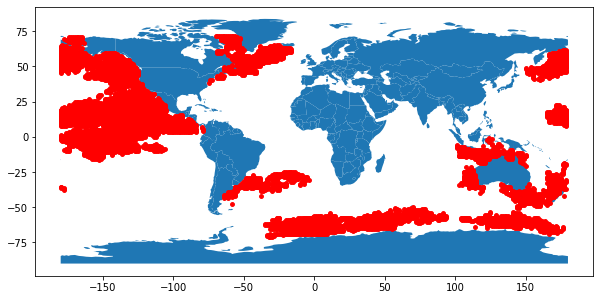

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

Return to SODA.

Extract the corresponding points in SODA, which represent the global warmming hotspots and Bay of Plenty in New Zealand.

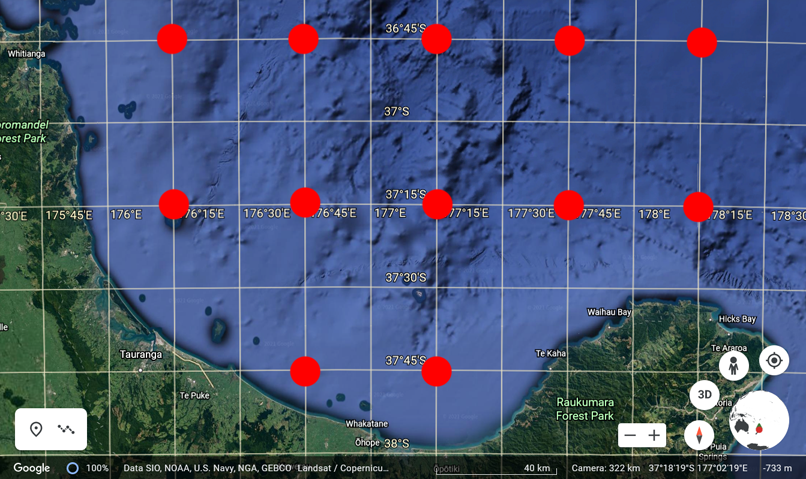

Preprocess the hotspots' coordinates.

In [16]:
df_anomalies_coordinates_nona = df_anomalies_coordinates_nona.drop(columns='geometry')

df_anomalies_coordinates_prep = df_anomalies_coordinates_nona[df_anomalies_coordinates_nona['lon'] % 1 != 0]
df_anomalies_coordinates_prep = df_anomalies_coordinates_prep[df_anomalies_coordinates_nona['lon'] % 1 != 0.5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [17]:
df_anomalies_coordinates_prep['lat'] = df_anomalies_coordinates_prep['lat'].round(decimals = 1)

In [18]:
df_anomalies_coordinates_prep = df_anomalies_coordinates_prep[df_anomalies_coordinates_prep['lat'] % 1 != 0]

In [19]:
df_anomalies_coordinates_prep['lat'] = df_anomalies_coordinates_prep['lat'].round(decimals = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Since the latitudes of the given coorindates use a 0.33 scale, we wanted to convert 0.67 into 0.75 and 0.33 into 0.25.

Set a condition to differentiate the 0.25 and 0.75 points.

In [20]:
conditions = [
    (df_anomalies_coordinates_prep['lat'] % 1 < 0.5),
    (df_anomalies_coordinates_prep['lat'] % 1 > 0.5)
    ]
values = [0.75, 0.25]
df_anomalies_coordinates_prep['lat_flag'] = np.select(conditions, values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
df_anomalies_coordinates_prep

,lat,lon,sst,lat_flag
5591,-71.3,-31.25,1.104444,0.25
5877,-70.7,-33.75,1.080000,0.75
5879,-70.7,-31.25,1.642000,0.75
5881,-70.7,-28.75,1.477500,0.75
6455,-69.3,-31.25,1.420000,0.25
...,...,...,...,...
67195,71.3,-66.25,4.805789,0.75
67197,71.3,-63.75,3.855263,0.75
67199,71.3,-61.25,3.931428,0.75
67201,71.3,-58.75,3.017500,0.75


In [22]:
conditions = [
    (df_anomalies_coordinates_prep['lat_flag'] < 0.5),
    (df_anomalies_coordinates_prep['lat_flag'] > 0.5)
    ]
values = [df_anomalies_coordinates_prep['lat'] + 0.05, df_anomalies_coordinates_prep['lat'] - 0.05]
df_anomalies_coordinates_prep['lat'] = np.select(conditions, values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
df_anomalies_coordinates_prep

,lat,lon,sst,lat_flag
5591,-71.25,-31.25,1.104444,0.25
5877,-70.75,-33.75,1.080000,0.75
5879,-70.75,-31.25,1.642000,0.75
5881,-70.75,-28.75,1.477500,0.75
6455,-69.25,-31.25,1.420000,0.25
...,...,...,...,...
67195,71.25,-66.25,4.805789,0.75
67197,71.25,-63.75,3.855263,0.75
67199,71.25,-61.25,3.931428,0.75
67201,71.25,-58.75,3.017500,0.75


Formally, we create a dataframe of the coordinates of the global warmming hotspots and a dataframe of the coordinates of the selected Bay of Plenty sea area.

In [24]:
global_coords = df_anomalies_coordinates_prep.drop(columns=['sst', 'lat_flag'])
global_coords = global_coords.rename(columns={'lat': 'latitude', 'lon': 'longitude'})

d = {'lat': [-37.75, -37.75, -37.25, -37.25, -37.25, -37.25, -37.25, -36.75, -36.75, -36.75, -36.75, -36.75], 
     'lon': [176.75, 177.25, 176.25, 176.75, 177.25, 177.75, 178.25, 176.25, 176.75, 177.25, 177.75, 178.25]}
bop_coords = pd.DataFrame(data=d)
bop_coords = bop_coords.rename(columns={'lat': 'latitude', 'lon': 'longitude'})

In [25]:
global_coords

,latitude,longitude
5591,-71.25,-31.25
5877,-70.75,-33.75
5879,-70.75,-31.25
5881,-70.75,-28.75
6455,-69.25,-31.25
...,...,...
67195,71.25,-66.25
67197,71.25,-63.75
67199,71.25,-61.25
67201,71.25,-58.75


In [26]:
bop_coords

,latitude,longitude
0,-37.75,176.75
1,-37.75,177.25
2,-37.25,176.25
3,-37.25,176.75
4,-37.25,177.25
5,-37.25,177.75
6,-37.25,178.25
7,-36.75,176.25
8,-36.75,176.75
9,-36.75,177.25


At this stage, these coorindates are not used.

Obtain SST anomaly maps from SST maps in SODA.

In [27]:
soda

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 330, longitude: 720, time: 432)
Coordinates:
  * time       (time) float64 3.168e+08 3.195e+08 ... 1.448e+09 1.45e+09
  * depth      (depth) float32 5.034
  * latitude   (latitude) float32 -74.75 -74.25 -73.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Data variables:
    temp       (time, depth, latitude, longitude) float32 ...
Attributes: (12/47)
    _CoordSysBuilder:              ucar.nc2.internal.dataset.conv.DefaultConv...
    acknowledgement:               The SODA3 project is funded by the US Nati...
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    Created_by:                    Gennady Chepurin and Ligang Chen
    creation_date:                 October, 2016
    ...                            ...
    summary:                       SODA3.3.1 ocean state, forced by MERRA2. T...
    time_coverage_end:             2015-12-16T00:00:00Z
    time_coverage_start:           1980-01-16T00:00:00Z
    title:                         SODA 3.3.1 Ocean State, 1/2°, Global, 1980...
    Website:                       https://www.atmos.umd.edu/~ocean/
    Westernmost_Easting:           0.25

Set a beginning year and an end year to compute the monthly long-term average temperatures.

In [28]:
start_year = 1970
end_year = 1999

In [29]:
start_month = (start_year - 1970) * 12
end_month = (end_year - 1970) * 12

In [30]:
soda_sst = np.zeros((432,1,330,720))
soda_sst[:,:,:,:] = soda.variables['temp'][0:432,:,:,:]

Drop the level dimension, since there is only one value.

In [31]:
soda_sst = np.squeeze(soda_sst, axis=1)

In [32]:
soda_sst_list = soda_sst.tolist()

In [33]:
months = list(range(0, 432))
monthly_average_all = []

for i in range(12):
  individual_month = months[i + start_month : end_month : 12]
  average = np.zeros((330,720))
  for j in range(len(individual_month)):
    average += soda_sst[individual_month[j]]
    # average_map += np.array(individual_month[j])
  monthly_average = average / len(individual_month)
  monthly_average_all.append(monthly_average)
  print("Month " + str(i+1) + " is appended.")

Month 1 is appended.
Month 2 is appended.
Month 3 is appended.
Month 4 is appended.
Month 5 is appended.
Month 6 is appended.
Month 7 is appended.
Month 8 is appended.
Month 9 is appended.
Month 10 is appended.
Month 11 is appended.
Month 12 is appended.


In [34]:
len(monthly_average_all)

12

Plot the January and July average SST maps.

Since they are numpy arrays, the spatial and temporal scales have been lost.

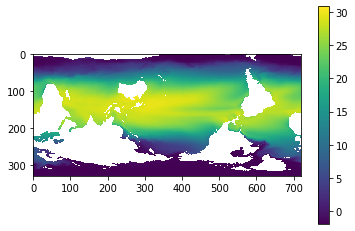

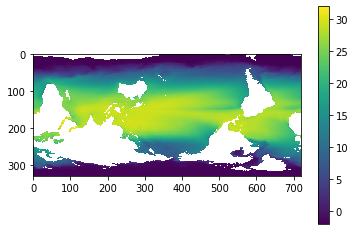

In [35]:
plt.imshow(monthly_average_all[0], interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

plt.imshow(monthly_average_all[6], interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

Subtract the average SST maps from the SST maps to obtain the SST anomaly maps by month.

In [36]:
monthly_average_all_432 = []
monthly_average_all_432 = monthly_average_all
print(len(monthly_average_all))
print(len(monthly_average_all_432))

12
12


In [37]:
for i in range(432 - 12):
  monthly_average_all_432.append(monthly_average_all_432[i])

print(len(monthly_average_all_432))

432


In [38]:
soda_sst_anomaly_list = []

for i in range(432):
  soda_sst_anomaly_list.append(soda_sst[i] - monthly_average_all_432[i])

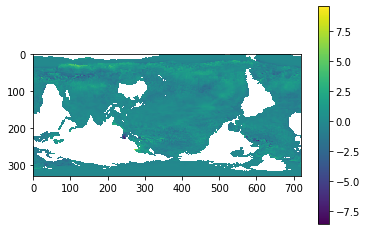

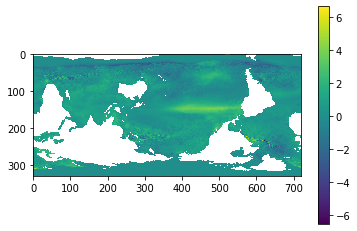

In [39]:
plt.imshow(soda_sst_anomaly_list[11], interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

plt.imshow(soda_sst_anomaly_list[431], interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

Plot the two figures in one figure.

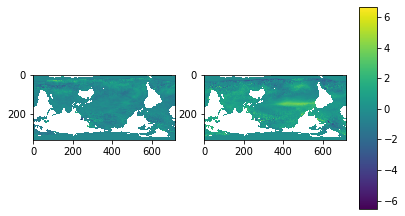

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2)

im1 = axes[0].imshow(soda_sst_anomaly_list[11], interpolation="nearest", origin="upper")
im2 = axes[1].imshow(soda_sst_anomaly_list[431], interpolation="nearest", origin="upper")

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

In [41]:
soda_sst_anomaly = np.array(soda_sst_anomaly_list)

In [42]:
soda_sst_anomaly.shape

(432, 330, 720)

Extract one point in Bay of Plenty from the tensor, which is getting a time series with a shape of (432, 1, 1) from the (432, 330, 720) spatio-temporal array.

Select the point (37.25 S, 177.25 E) for example.

In [43]:
soda

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 330, longitude: 720, time: 432)
Coordinates:
  * time       (time) float64 3.168e+08 3.195e+08 ... 1.448e+09 1.45e+09
  * depth      (depth) float32 5.034
  * latitude   (latitude) float32 -74.75 -74.25 -73.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Data variables:
    temp       (time, depth, latitude, longitude) float32 ...
Attributes: (12/47)
    _CoordSysBuilder:              ucar.nc2.internal.dataset.conv.DefaultConv...
    acknowledgement:               The SODA3 project is funded by the US Nati...
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    Created_by:                    Gennady Chepurin and Ligang Chen
    creation_date:                 October, 2016
    ...                            ...
    summary:                       SODA3.3.1 ocean state, forced by MERRA2. T...
    time_coverage_end:             2015-12-16T00:00:00Z
    time_coverage_start:           1980-01-16T00:00:00Z
    title:                         SODA 3.3.1 Ocean State, 1/2°, Global, 1980...
    Website:                       https://www.atmos.umd.edu/~ocean/
    Westernmost_Easting:           0.25

We do not know how to find the indeces (the positions) of (37.15 S, 177.15 E) in the xarray object.

Simply, use the calculation. pos(latitude) = (-37.25 - (-74.75)) / 0.5 = 75, pos(longitude) = (177.25 - 0.25) / 0.5 = 354

In [44]:
soda_sst_anomaly_bop = soda_sst_anomaly[:, 75, 354]

This is the time series of the SST anomalies at one point in Bay of Plenty, which is y.

In [45]:
soda_sst_anomaly_bop.shape

(432,)

Use CNNs to perform EDA. This section is currently suspended.

In [46]:
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
from torch.autograd import Variable

Split data into the training and the test.

In [47]:
"""
soda_sst_anomaly_add_dim = soda_sst_anomaly[..., np.newaxis]
soda_sst_anomaly_add_dim = np.moveaxis(soda_sst_anomaly_add_dim, -1, 1)
"""

'\nsoda_sst_anomaly_add_dim = soda_sst_anomaly[..., np.newaxis]\nsoda_sst_anomaly_add_dim = np.moveaxis(soda_sst_anomaly_add_dim, -1, 1)\n'

In [48]:
"""
soda_sst_anomaly_add_dim.shape
"""

'\nsoda_sst_anomaly_add_dim.shape\n'

In [49]:
"""
x_train, x_test, y_train, y_test = train_test_split(soda_sst_anomaly_add_dim, soda_sst_anomaly_bop, test_size=0.2)
"""

'\nx_train, x_test, y_train, y_test = train_test_split(soda_sst_anomaly_add_dim, soda_sst_anomaly_bop, test_size=0.2)\n'

In [50]:
"""
print(x_train.shape, x_test.shape)
"""

'\nprint(x_train.shape, x_test.shape)\n'

Create a CNN with PyTorch.

In [51]:
"""
evice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
"""

"\nevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')\n"

In [52]:
"""
EPOCH = 100
BATCH_SIZE = 16
LR = 0.00001
"""

'\nEPOCH = 100\nBATCH_SIZE = 16\nLR = 0.00001\n'

In [53]:
"""
train = []
test = []

for i in range(len(x_train)):
  train.append((x_train[i], y_train[i]))

for i in range(len(x_test)):
  test.append((x_test[i], y_test[i]))
"""

'\ntrain = []\ntest = []\n\nfor i in range(len(x_train)):\n  train.append((x_train[i], y_train[i]))\n\nfor i in range(len(x_test)):\n  test.append((x_test[i], y_test[i]))\n'

In [54]:
"""
train_loader = Data.DataLoader(dataset=train, batch_size=len(train), shuffle=False)
test_loader = Data.DataLoader(dataset=test, batch_size=len(test), shuffle=False)

print(type(train_loader))
"""

'\ntrain_loader = Data.DataLoader(dataset=train, batch_size=len(train), shuffle=False)\ntest_loader = Data.DataLoader(dataset=test, batch_size=len(test), shuffle=False)\n\nprint(type(train_loader))\n'

In [55]:
"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=4,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.Tanh(),
        )
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 4, 3, 1, 1),
            nn.Tanh(),
        )
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(4, 1, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        output = self.conv3(x)
        #x = x.view(x.size(0), -1)
        #output = self.out(x)
        return output, x
"""

'\nclass CNN(nn.Module):\n    def __init__(self):\n        super(CNN, self).__init__()\n        self.conv1 = nn.Sequential(\n            nn.Conv2d(\n                in_channels=1,\n                out_channels=4,\n                kernel_size=3,\n                stride=1,\n                padding=1,\n            ),\n            nn.Tanh(),\n        )\n        self.maxpool1 = nn.MaxPool2d(2)\n        self.conv2 = nn.Sequential(\n            nn.Conv2d(4, 4, 3, 1, 1),\n            nn.Tanh(),\n        )\n        self.maxpool2 = nn.MaxPool2d(2)\n        self.conv3 = nn.Sequential(\n            nn.Conv2d(4, 1, 3, 1, 1),\n            nn.Tanh(),\n        )\n\n    def forward(self, x):\n        x = self.conv1(x)\n        x = self.conv2(x)\n        output = self.conv3(x)\n        #x = x.view(x.size(0), -1)\n        #output = self.out(x)\n        return output, x\n'

In [56]:
"""
cnn = CNN().double()

print(cnn)
"""

'\ncnn = CNN().double()\n\nprint(cnn)\n'

In [57]:
"""
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.MSELoss()
"""

'\noptimizer = torch.optim.Adam(cnn.parameters(), lr=LR)\nloss_func = nn.MSELoss()\n'

In [58]:
"""
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)
        b_y = Variable(y)

        output = cnn(b_x)[0]
        #output = output.reshape(-1)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for step, (x, y) in enumerate(train_all_loader):
        c_x = Variable(x)
        c_y = Variable(y)

    for step, (x, y) in enumerate(test_loader):
        d_x = Variable(x)
        d_y = Variable(y)

        if step % 100 == 0:
            
            pred_train_y, last_layer = cnn(c_x)
            train_mse = loss_func(pred_train_y, c_y)

            pred_test_y, last_layer = cnn(d_x)
            test_mse = loss_func(pred_test_y, d_y)

            print('Epoch: ', epoch, '| trainig loss: %.4f' % loss.data, '| training MSE: %.4f' % train_mse, '| test MSE: %.4f' % test_mse)
"""

"\nfor epoch in range(EPOCH):\n    for step, (x, y) in enumerate(train_loader):\n        b_x = Variable(x)\n        b_y = Variable(y)\n\n        output = cnn(b_x)[0]\n        #output = output.reshape(-1)\n        loss = loss_func(output, b_y)\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    for step, (x, y) in enumerate(train_all_loader):\n        c_x = Variable(x)\n        c_y = Variable(y)\n\n    for step, (x, y) in enumerate(test_loader):\n        d_x = Variable(x)\n        d_y = Variable(y)\n\n        if step % 100 == 0:\n            \n            pred_train_y, last_layer = cnn(c_x)\n            train_mse = loss_func(pred_train_y, c_y)\n\n            pred_test_y, last_layer = cnn(d_x)\n            test_mse = loss_func(pred_test_y, d_y)\n\n            print('Epoch: ', epoch, '| trainig loss: %.4f' % loss.data, '| training MSE: %.4f' % train_mse, '| test MSE: %.4f' % test_mse)\n"

Use GNNs to perform EDA.

Refer to [the tutorial on UvA DL Notebooks](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html).

In [59]:
import os
import json
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [60]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


Prepare the feature matrix.



In [61]:
soda_sst_anomaly.shape

(432, 330, 720)

In [62]:
soda_sst_anomaly_transposed = soda_sst_anomaly.transpose(1,2,0)

In [63]:
soda_sst_anomaly_flattened = soda_sst_anomaly_transposed.reshape(soda_sst_anomaly.shape[1] * soda_sst_anomaly.shape[2],432)

In [64]:
soda_sst_anomaly_flattened.shape

(237600, 432)

In [65]:
soda_sst_anomaly_flattened

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.07354643, -0.07722266, -0.0833161 , ...,  0.04037802,
         0.02836079,  0.04108443],
       [-0.07353822, -0.07715413, -0.08338847, ...,  0.04038749,
         0.02851528,  0.0412538 ],
       [-0.07353018, -0.07708971, -0.08345621, ...,  0.0403959 ,
         0.02866005,  0.04141222]])

The feature matrix: the feature is SST anomalies, 237600 rows represent nodes, and 432 columns represent 432 months.

In [66]:
feature_matrix = soda_sst_anomaly_flattened

Prepare the adjacency matrix

We experiment with a matrix with all elements being 1. Later, we will create an adjacency matrix using geological distances.

In [67]:
#indentiy_matrix = np.identity(feature_matrix.shape[0])

Ignore the following comments since we intended to create an indeity matrix as the adjacency matrix.

-----

It demonstrates that creating a 237600 x 237600 identity matrix could run out of RAM and cause Colab crashed. It would consume more later when we train neural networks on this large adjency matrix.

We have to include fewer nodes.

After experimenting, we have found creating a 40000 x 40000 or smaller identity matrix with np.identity() is possible.

In [68]:
soda_sst_anomaly_smaller = soda_sst_anomaly[:,::4,::4]

In [69]:
soda_sst_anomaly_transposed = soda_sst_anomaly_smaller.transpose(1,2,0)
soda_sst_anomaly_flattened = soda_sst_anomaly_transposed.reshape(soda_sst_anomaly_smaller.shape[1] * soda_sst_anomaly_smaller.shape[2],432)
soda_sst_anomaly_flattened.shape

(14940, 432)

In [70]:
feature_matrix = soda_sst_anomaly_flattened

In [71]:
#indentiy_matrix = np.identity(feature_matrix.shape[0])
one_matrix = np.ones((feature_matrix.shape[0], feature_matrix.shape[0]))

The adjacency matrix: a 14940 x 14940 matrix

In [72]:
#adj_matrix = indentiy_matrix
adj_matrix = one_matrix

The label vector: a time series vector with 432 elements that represent the SST anomalies in Bay of Plenty.

In [73]:
label_vector = soda_sst_anomaly_bop

Update the matrices with a lead month. Set a lead month.

In [74]:
lead_month = 1
feature_matrix = soda_sst_anomaly_flattened[:,:-lead_month:]
adj_matrix
label_vector = soda_sst_anomaly_bop[lead_month::]

Create a GNN with the code from the reference.

In [75]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [76]:
node_feats = torch.tensor(np.expand_dims(soda_sst_anomaly_flattened[:,:-lead_month:], axis=0)).float()
#adj_matrix = torch.tensor(np.expand_dims(indentiy_matrix, axis=0)).float()
adj_matrix = torch.tensor(np.expand_dims(one_matrix, axis=0)).float()

In [77]:
node_feats.shape

torch.Size([1, 14940, 431])

In [78]:
adj_matrix.shape

torch.Size([1, 14940, 14940])

In [79]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [80]:
print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         ...,
         [-0.0848, -0.0753, -0.0821,  ...,  0.0777,  0.0610,  0.0340],
         [-0.0852, -0.0763, -0.0828,  ...,  0.0790,  0.0613,  0.0345],
         [-0.0804, -0.0764, -0.0821,  ...,  0.0801,  0.0621,  0.0365]]])

Adjacency matrix:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


In [81]:
temp_list = []
for i in range(0, feature_matrix.shape[1]):
  element = [0] * feature_matrix.shape[1]
  element[i] = 1
  element = [float(item) for item in element] # Convert the type into float.
  temp_list.append(element)

layer = GCNLayer(c_in=feature_matrix.shape[1], c_out=feature_matrix.shape[1])
layer.projection.weight.data = torch.tensor(temp_list)

In [82]:
layer.projection.bias.data = torch.Tensor([0] * feature_matrix.shape[1])

In [83]:
node_feats.shape

torch.Size([1, 14940, 431])

In [84]:
#layer = GCNLayer(c_in=feature_matrix.shape[1], c_out=feature_matrix.shape[1])
#layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
#layer.projection.bias.data = torch.Tensor([[0., 0.]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Input features tensor([[[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         ...,
         [-0.0848, -0.0753, -0.0821,  ...,  0.0777,  0.0610,  0.0340],
         [-0.0852, -0.0763, -0.0828,  ...,  0.0790,  0.0613,  0.0345],
         [-0.0804, -0.0764, -0.0821,  ...,  0.0801,  0.0621,  0.0365]]])
Output features tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],

The output tensor generates all NAs. We must figure out the reason, perhaps due to the all 1 adjacency matrix.

We deduced such NAs were casued by the NAs in the feature matrix, which represent the continental points. Hence, remove the NAs.

Refer to [the Q&A: Removing nan values from an array](https://stackoverflow.com/questions/11620914/removing-nan-values-from-an-array), to drop the land points, i.e. the vectors that contain NAs.

In [85]:
def dropna(arr, *args, **kwarg):
    assert isinstance(arr, np.ndarray)
    dropped=pd.DataFrame(arr).dropna(*args, **kwarg).values
    if arr.ndim==1:
        dropped=dropped.flatten()
    return dropped

x = np.array([1400, 1500, 1600, np.nan, np.nan, np.nan ,1700])
y = np.array([[1400, 1500, 1600], [np.nan, 0, np.nan] ,[1700,1800,np.nan]] )


print('='*20+' 1D Case: ' +'='*20+'\nInput:\n',x,sep='')
print('\ndropna:\n',dropna(x),sep='')

print('\n\n'+'='*20+' 2D Case: ' +'='*20+'\nInput:\n',y,sep='')
print('\ndropna (rows):\n',dropna(y),sep='')
print('\ndropna (columns):\n',dropna(y,axis=1),sep='')

print('\n\n'+'='*20+' x[np.logical_not(np.isnan(x))] for 2D: ' +'='*20+'\nInput:\n',y,sep='')
print('\ndropna:\n',x[np.logical_not(np.isnan(x))],sep='')

==================== 1D Case: ====================
Input:
[1400. 1500. 1600.   nan   nan   nan 1700.]

dropna:
[1400. 1500. 1600. 1700.]


==================== 2D Case: ====================
Input:
[[1400. 1500. 1600.]
 [  nan    0.   nan]
 [1700. 1800.   nan]]

dropna (rows):
[[1400. 1500. 1600.]]

dropna (columns):
[[1500.]
 [   0.]
 [1800.]]


==================== x[np.logical_not(np.isnan(x))] for 2D: ====================
Input:
[[1400. 1500. 1600.]
 [  nan    0.   nan]
 [1700. 1800.   nan]]

dropna:
[1400. 1500. 1600. 1700.]


In [86]:
soda_sst_anomaly_no_land_flattened = dropna(soda_sst_anomaly_flattened)

In [87]:
print(soda_sst_anomaly_no_land_flattened)
print(len(soda_sst_anomaly_no_land_flattened))

[[ 4.27218640e-01 -4.44085460e-01  2.99155630e-02 ... -1.46890591e-02
  -1.20266840e-02 -1.15835391e-01]
 [ 2.07235922e+00  1.16289895e+00  2.86653453e-01 ... -2.07908236e-02
  -8.15232047e-03 -8.84413288e-02]
 [ 1.81294080e+00  1.21645929e+00  2.02618870e-01 ... -1.27145751e-03
  -5.06117426e-04 -9.66755563e-02]
 ...
 [-8.47671649e-02 -7.53168690e-02 -8.20506893e-02 ...  6.10092961e-02
   3.39506330e-02  4.58371146e-02]
 [-8.52476646e-02 -7.62704200e-02 -8.28284518e-02 ...  6.12597835e-02
   3.45223813e-02  4.64822753e-02]
 [-8.04304583e-02 -7.64128627e-02 -8.21182481e-02 ...  6.21488752e-02
   3.64618589e-02  4.76937911e-02]]
10942


In [88]:
feature_matrix = soda_sst_anomaly_no_land_flattened
one_matrix = np.ones((feature_matrix.shape[0], feature_matrix.shape[0]))
node_feats = torch.tensor(np.expand_dims(soda_sst_anomaly_no_land_flattened[:,:-lead_month:], axis=0)).float()
adj_matrix = torch.tensor(np.expand_dims(one_matrix, axis=0)).float()
lead_month = 1
feature_matrix = soda_sst_anomaly_no_land_flattened[:,:-lead_month:]

In [89]:
print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[ 4.2722e-01, -4.4409e-01,  2.9916e-02,  ..., -1.6730e-02,
          -1.4689e-02, -1.2027e-02],
         [ 2.0724e+00,  1.1629e+00,  2.8665e-01,  ..., -1.3566e-02,
          -2.0791e-02, -8.1523e-03],
         [ 1.8129e+00,  1.2165e+00,  2.0262e-01,  ...,  2.8281e-04,
          -1.2715e-03, -5.0612e-04],
         ...,
         [-8.4767e-02, -7.5317e-02, -8.2051e-02,  ...,  7.7687e-02,
           6.1009e-02,  3.3951e-02],
         [-8.5248e-02, -7.6270e-02, -8.2828e-02,  ...,  7.9027e-02,
           6.1260e-02,  3.4522e-02],
         [-8.0430e-02, -7.6413e-02, -8.2118e-02,  ...,  8.0071e-02,
           6.2149e-02,  3.6462e-02]]])

Adjacency matrix:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


Input the matrices into the GNN.

In [90]:
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Input features tensor([[[ 4.2722e-01, -4.4409e-01,  2.9916e-02,  ..., -1.6730e-02,
          -1.4689e-02, -1.2027e-02],
         [ 2.0724e+00,  1.1629e+00,  2.8665e-01,  ..., -1.3566e-02,
          -2.0791e-02, -8.1523e-03],
         [ 1.8129e+00,  1.2165e+00,  2.0262e-01,  ...,  2.8281e-04,
          -1.2715e-03, -5.0612e-04],
         ...,
         [-8.4767e-02, -7.5317e-02, -8.2051e-02,  ...,  7.7687e-02,
           6.1009e-02,  3.3951e-02],
         [-8.5248e-02, -7.6270e-02, -8.2828e-02,  ...,  7.9027e-02,
           6.1260e-02,  3.4522e-02],
         [-8.0430e-02, -7.6413e-02, -8.2118e-02,  ...,  8.0071e-02,
           6.2149e-02,  3.6462e-02]]])
Output features tensor([[[0.2427, 0.1409, 0.0887,  ..., 0.39

We got an output feature matrix without NAs.

However, the rows in the output feature matrix are the same, possibly resulting from the adjacency matrix being a matrix of ones.

Try to generate an adjacency matrix with non-identical random values.

Since in our case, if we use geographical distances to denote the edges, the edges are undirected, so the adjacency matrix is a symmetric matrix.

Generate a symmetric matrix with the diagonal being all one.

Refer to [the Q&A: Generating Symmetric Matrices in Numpy](https://stackoverflow.com/questions/10806790/generating-symmetric-matrices-in-numpy).

In [91]:
import random

N = feature_matrix.shape[0]
matrix = np.random.random_integers(0, 100, size=(N,N))
matrix_symm = (matrix + matrix.T) / 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 100 + 1) instead
  after removing the cwd from sys.path.


In [92]:
matrix_symm

array([[45. , 31.5, 39.5, ..., 53. , 29. , 60. ],
       [31.5, 17. , 43. , ..., 52.5, 57.5, 47. ],
       [39.5, 43. , 91. , ..., 69.5, 58. , 35. ],
       ...,
       [53. , 52.5, 69.5, ..., 10. , 89. , 75.5],
       [29. , 57.5, 58. , ..., 89. , 39. , 30.5],
       [60. , 47. , 35. , ..., 75.5, 30.5, 90. ]])

In [93]:
np.fill_diagonal(matrix_symm, 1)
matrix_symm_diag = matrix_symm

In [94]:
matrix_symm_diag

array([[ 1. , 31.5, 39.5, ..., 53. , 29. , 60. ],
       [31.5,  1. , 43. , ..., 52.5, 57.5, 47. ],
       [39.5, 43. ,  1. , ..., 69.5, 58. , 35. ],
       ...,
       [53. , 52.5, 69.5, ...,  1. , 89. , 75.5],
       [29. , 57.5, 58. , ..., 89. ,  1. , 30.5],
       [60. , 47. , 35. , ..., 75.5, 30.5,  1. ]])

In [95]:
adj_matrix = torch.tensor(np.expand_dims(matrix_symm_diag, axis=0)).float()

In [96]:
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[ 1.0000, 31.5000, 39.5000,  ..., 53.0000, 29.0000, 60.0000],
         [31.5000,  1.0000, 43.0000,  ..., 52.5000, 57.5000, 47.0000],
         [39.5000, 43.0000,  1.0000,  ..., 69.5000, 58.0000, 35.0000],
         ...,
         [53.0000, 52.5000, 69.5000,  ...,  1.0000, 89.0000, 75.5000],
         [29.0000, 57.5000, 58.0000,  ..., 89.0000,  1.0000, 30.5000],
         [60.0000, 47.0000, 35.0000,  ..., 75.5000, 30.5000,  1.0000]]])
Input features tensor([[[ 4.2722e-01, -4.4409e-01,  2.9916e-02,  ..., -1.6730e-02,
          -1.4689e-02, -1.2027e-02],
         [ 2.0724e+00,  1.1629e+00,  2.8665e-01,  ..., -1.3566e-02,
          -2.0791e-02, -8.1523e-03],
         [ 1.8129e+00,  1.2165e+00,  2.0262e-01,  ...,  2.8281e-04,
          -1.2715e-03, -5.0612e-04],
         ...,
         [-8.4767e-02, -7.5317e-02, -8.2051e-02,  ...,  7.7687e-02,
           6.1009e-02,  3.3951e-02],
         [-8.5248e-02, -7.6270e-02, -8.2828e-02,  ...,  7.9027e-02,
           6.1260e-02,  

We got the rows with different predicted values.

The following code is about GATs.

In [97]:
"""
class GATLayer(nn.Module):

    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        '''
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        '''
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        '''
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        '''
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats
"""

'\nclass GATLayer(nn.Module):\n\n    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):\n        \'\'\'\n        Inputs:\n            c_in - Dimensionality of input features\n            c_out - Dimensionality of output features\n            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The\n                        output features are equally split up over the heads if concat_heads=True.\n            concat_heads - If True, the output of the different heads is concatenated instead of averaged.\n            alpha - Negative slope of the LeakyReLU activation.\n        \'\'\'\n        super().__init__()\n        self.num_heads = num_heads\n        self.concat_heads = concat_heads\n        if self.concat_heads:\n            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."\n            c_out = c_out // num_heads\n\n        # Sub-modules and parameters needed in the layer\n        self

This could crash on Colab.

In [98]:
"""
layer = GATLayer(feature_matrix.shape[1], feature_matrix.shape[1], num_heads=feature_matrix.shape[1])
layer.projection.weight.data = torch.tensor(temp_list)
layer.projection.bias.data = torch.Tensor([0] * feature_matrix.shape[1])

#layer = GATLayer(2, 2, num_heads=2)
#layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
#layer.projection.bias.data = torch.Tensor([0., 0.])

#layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]]) # Need to figure out this step.

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)
"""

'\nlayer = GATLayer(feature_matrix.shape[1], feature_matrix.shape[1], num_heads=feature_matrix.shape[1])\nlayer.projection.weight.data = torch.tensor(temp_list)\nlayer.projection.bias.data = torch.Tensor([0] * feature_matrix.shape[1])\n\n#layer = GATLayer(2, 2, num_heads=2)\n#layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])\n#layer.projection.bias.data = torch.Tensor([0., 0.])\n\n#layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]]) # Need to figure out this step.\n\nwith torch.no_grad():\n    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)\n\nprint("Adjacency matrix", adj_matrix)\nprint("Input features", node_feats)\nprint("Output features", out_feats)\n'

In [99]:
soda

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 330, longitude: 720, time: 432)
Coordinates:
  * time       (time) float64 3.168e+08 3.195e+08 ... 1.448e+09 1.45e+09
  * depth      (depth) float32 5.034
  * latitude   (latitude) float32 -74.75 -74.25 -73.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
Data variables:
    temp       (time, depth, latitude, longitude) float32 ...
Attributes: (12/47)
    _CoordSysBuilder:              ucar.nc2.internal.dataset.conv.DefaultConv...
    acknowledgement:               The SODA3 project is funded by the US Nati...
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    Created_by:                    Gennady Chepurin and Ligang Chen
    creation_date:                 October, 2016
    ...                            ...
    summary:                       SODA3.3.1 ocean state, forced by MERRA2. T...
    time_coverage_end:             2015-12-16T00:00:00Z
    time_coverage_start:           1980-01-16T00:00:00Z
    title:                         SODA 3.3.1 Ocean State, 1/2°, Global, 1980...
    Website:                       https://www.atmos.umd.edu/~ocean/
    Westernmost_Easting:           0.25

In [100]:
# soda_fewer = soda.longitude[::5]

Select every five longitudes and latitudes.

In [101]:
lons, lats = np.meshgrid(soda.longitude.values[::5], soda.latitude.values[::5])

In [102]:
lons, lats

(array([[2.5000e-01, 2.7500e+00, 5.2500e+00, ..., 3.5275e+02, 3.5525e+02,
         3.5775e+02],
        [2.5000e-01, 2.7500e+00, 5.2500e+00, ..., 3.5275e+02, 3.5525e+02,
         3.5775e+02],
        [2.5000e-01, 2.7500e+00, 5.2500e+00, ..., 3.5275e+02, 3.5525e+02,
         3.5775e+02],
        ...,
        [2.5000e-01, 2.7500e+00, 5.2500e+00, ..., 3.5275e+02, 3.5525e+02,
         3.5775e+02],
        [2.5000e-01, 2.7500e+00, 5.2500e+00, ..., 3.5275e+02, 3.5525e+02,
         3.5775e+02],
        [2.5000e-01, 2.7500e+00, 5.2500e+00, ..., 3.5275e+02, 3.5525e+02,
         3.5775e+02]], dtype=float32),
 array([[-74.75, -74.75, -74.75, ..., -74.75, -74.75, -74.75],
        [-72.25, -72.25, -72.25, ..., -72.25, -72.25, -72.25],
        [-69.75, -69.75, -69.75, ..., -69.75, -69.75, -69.75],
        ...,
        [ 82.75,  82.75,  82.75, ...,  82.75,  82.75,  82.75],
        [ 85.25,  85.25,  85.25, ...,  85.25,  85.25,  85.25],
        [ 87.75,  87.75,  87.75, ...,  87.75,  87.75,  87.75]],
  

Calculate the geological distances and create a corresponding adjacency matrix.

In [103]:
lons *= np.pi/180
lats *= np.pi/180

In [104]:
lons, lats

(array([[4.3633231e-03, 4.7996555e-02, 9.1629788e-02, ..., 6.1566491e+00,
         6.2002821e+00, 6.2439156e+00],
        [4.3633231e-03, 4.7996555e-02, 9.1629788e-02, ..., 6.1566491e+00,
         6.2002821e+00, 6.2439156e+00],
        [4.3633231e-03, 4.7996555e-02, 9.1629788e-02, ..., 6.1566491e+00,
         6.2002821e+00, 6.2439156e+00],
        ...,
        [4.3633231e-03, 4.7996555e-02, 9.1629788e-02, ..., 6.1566491e+00,
         6.2002821e+00, 6.2439156e+00],
        [4.3633231e-03, 4.7996555e-02, 9.1629788e-02, ..., 6.1566491e+00,
         6.2002821e+00, 6.2439156e+00],
        [4.3633231e-03, 4.7996555e-02, 9.1629788e-02, ..., 6.1566491e+00,
         6.2002821e+00, 6.2439156e+00]], dtype=float32),
 array([[-1.3046336, -1.3046336, -1.3046336, ..., -1.3046336, -1.3046336,
         -1.3046336],
        [-1.2610004, -1.2610004, -1.2610004, ..., -1.2610004, -1.2610004,
         -1.2610004],
        [-1.2173672, -1.2173672, -1.2173672, ..., -1.2173672, -1.2173672,
         -1.2173672]

In [105]:
points = np.concatenate([np.expand_dims(lats.flatten(),-1), np.expand_dims(lons.flatten(),-1)],-1)

In [106]:
from sklearn.metrics.pairwise import haversine_distances
distance = 6371*haversine_distances(points)

In [107]:
distance

array([[0.00000000e+00, 7.31139423e+01, 1.46195495e+02, ...,
        1.80710484e+04, 1.80700085e+04, 1.80693840e+04],
       [7.31139423e+01, 0.00000000e+00, 7.31139462e+01, ...,
        1.80725024e+04, 1.80710484e+04, 1.80700085e+04],
       [1.46195495e+02, 7.31139462e+01, 0.00000000e+00, ...,
        1.80743686e+04, 1.80725024e+04, 1.80710484e+04],
       ...,
       [1.80710484e+04, 1.80725024e+04, 1.80743686e+04, ...,
        0.00000000e+00, 1.09127969e+01, 2.18205272e+01],
       [1.80700085e+04, 1.80710484e+04, 1.80725024e+04, ...,
        1.09127969e+01, 0.00000000e+00, 1.09129162e+01],
       [1.80693840e+04, 1.80700085e+04, 1.80710484e+04, ...,
        2.18205272e+01, 1.09129162e+01, 0.00000000e+00]])

Check the first two rows.

In [108]:
distance[0]

array([    0.        ,    73.11394227,   146.19549548, ...,
       18071.0483852 , 18070.00848982, 18069.38401193])

In [109]:
distance[1]

array([   73.11394227,     0.        ,    73.11394617, ...,
       18072.5023769 , 18071.04839226, 18070.00848544])

Change "0" into "1" at the diagonal.

In [110]:
distance_diag = distance
distance_diag[distance_diag==0] = 1

Get the reciprocals of every element, which can be normalization. The closer distance, the bigger value is and the more connection is between the two nodes. "1" demonstrates the point itself.

In [111]:
distance_diag

array([[1.00000000e+00, 7.31139423e+01, 1.46195495e+02, ...,
        1.80710484e+04, 1.80700085e+04, 1.80693840e+04],
       [7.31139423e+01, 1.00000000e+00, 7.31139462e+01, ...,
        1.80725024e+04, 1.80710484e+04, 1.80700085e+04],
       [1.46195495e+02, 7.31139462e+01, 1.00000000e+00, ...,
        1.80743686e+04, 1.80725024e+04, 1.80710484e+04],
       ...,
       [1.80710484e+04, 1.80725024e+04, 1.80743686e+04, ...,
        1.00000000e+00, 1.09127969e+01, 2.18205272e+01],
       [1.80700085e+04, 1.80710484e+04, 1.80725024e+04, ...,
        1.09127969e+01, 1.00000000e+00, 1.09129162e+01],
       [1.80693840e+04, 1.80700085e+04, 1.80710484e+04, ...,
        2.18205272e+01, 1.09129162e+01, 1.00000000e+00]])

In [112]:
distance_recip = np.reciprocal(distance_diag)

In [113]:
distance_recip

array([[1.00000000e+00, 1.36772819e-02, 6.84015603e-03, ...,
        5.53371326e-05, 5.53403171e-05, 5.53422297e-05],
       [1.36772819e-02, 1.00000000e+00, 1.36772812e-02, ...,
        5.53326805e-05, 5.53371325e-05, 5.53403171e-05],
       [6.84015603e-03, 1.36772812e-02, 1.00000000e+00, ...,
        5.53269673e-05, 5.53326805e-05, 5.53371326e-05],
       ...,
       [5.53371326e-05, 5.53326805e-05, 5.53269673e-05, ...,
        1.00000000e+00, 9.16355364e-02, 4.58284070e-02],
       [5.53403171e-05, 5.53371325e-05, 5.53326805e-05, ...,
        9.16355364e-02, 1.00000000e+00, 9.16345351e-02],
       [5.53422297e-05, 5.53403171e-05, 5.53371326e-05, ...,
        4.58284070e-02, 9.16345351e-02, 1.00000000e+00]])

In [114]:
distance_recip.shape

(9504, 9504)

In [115]:
"""
anomalies
lons, lats = np.meshgrid(anomalies.lat.values, anomalies.lon.values)
lons *= np.pi/180
lats *= np.pi/180
points = np.concatenate([np.expand_dims(lats.flatten(),-1), np.expand_dims(lons.flatten(),-1)],-1)
"""

'\nanomalies\nlons, lats = np.meshgrid(anomalies.lat.values, anomalies.lon.values)\nlons *= np.pi/180\nlats *= np.pi/180\npoints = np.concatenate([np.expand_dims(lats.flatten(),-1), np.expand_dims(lons.flatten(),-1)],-1)\n'

In [116]:
#distance = 6371*haversine_distances(points)

Get the corresponding feature matrix.

In [117]:
soda_sst_anomaly_smaller_2 = soda_sst_anomaly[:,::5,::5]

In [118]:
soda_sst_anomaly_smaller_2.shape

(432, 66, 144)

In [119]:
soda_sst_anomaly_transposed = soda_sst_anomaly_smaller_2.transpose(1,2,0)
soda_sst_anomaly_flattened = soda_sst_anomaly_transposed.reshape(soda_sst_anomaly_smaller_2.shape[1] * soda_sst_anomaly_smaller_2.shape[2],432)
soda_sst_anomaly_flattened.shape

(9504, 432)

Get the feature matrix.

In [120]:
feature_matrix = soda_sst_anomaly_flattened

Get the adjacency matrix.

In [121]:
adj_matrix = distance_recip

Reorganize the labels and predictive parameters.

In [122]:
label_vector = soda_sst_anomaly_bop

In [123]:
lead_month = 1
feature_matrix = soda_sst_anomaly_flattened[:,:-lead_month:]
adj_matrix
label_vector = soda_sst_anomaly_bop[lead_month::]

Reorganize the GNN.

In [124]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

Temporarily change NAs into "0."

In [125]:
node_feats = np.expand_dims(soda_sst_anomaly_flattened[:,:-lead_month:], axis=0)

node_feats = np.nan_to_num(node_feats, copy=True, nan=0.0)

In [126]:
node_feats = torch.tensor(node_feats).float()
#adj_matrix = torch.tensor(np.expand_dims(indentiy_matrix, axis=0)).float()
adj_matrix = torch.tensor(np.expand_dims(adj_matrix, axis=0)).float()

In [127]:
node_feats.shape

torch.Size([1, 9504, 431])

In [128]:
adj_matrix.shape

torch.Size([1, 9504, 9504])

In [129]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [130]:
print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.0933, -0.0901, -0.0921,  ...,  0.0956,  0.0939,  0.0746],
         [-0.0943, -0.0883, -0.0898,  ...,  0.0971,  0.0944,  0.0774],
         [-0.0889, -0.0843, -0.0886,  ...,  0.0997,  0.0951,  0.0800]]])

Adjacency matrix:
 tensor([[[1.0000e+00, 1.3677e-02, 6.8402e-03,  ..., 5.5337e-05,
          5.5340e-05, 5.5342e-05],
         [1.3677e-02, 1.0000e+00, 1.3677e-02,  ..., 5.5333e-05,
          5.5337e-05, 5.5340e-05],
         [6.8402e-03, 1.3677e-02, 1.0000e+00,  ..., 5.5327e-05,
          5.5333e-05, 5.5337e-05],
         ...,
         [5.5337e-05, 5.5333e-05, 5.5327e-05,  ..., 1.0000e+00,
          9.1636e-02, 4.5828e-02],
         [5.5340e-05, 5.5337e-05, 5.5333e-05,  ..., 9.1636e-02,
          1.0000e+00, 9.1635e-02],
         [5.5

In [131]:
temp_list = []
for i in range(0, feature_matrix.shape[1]):
  element = [0] * feature_matrix.shape[1]
  element[i] = 1
  element = [float(item) for item in element] # Convert the type into float.
  temp_list.append(element)

layer = GCNLayer(c_in=feature_matrix.shape[1], c_out=feature_matrix.shape[1])
layer.projection.weight.data = torch.tensor(temp_list)

In [132]:
layer.projection.bias.data = torch.Tensor([0] * feature_matrix.shape[1])

In [133]:
node_feats.shape

torch.Size([1, 9504, 431])

In [134]:
#layer = GCNLayer(c_in=feature_matrix.shape[1], c_out=feature_matrix.shape[1])
#layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
#layer.projection.bias.data = torch.Tensor([[0., 0.]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1.0000e+00, 1.3677e-02, 6.8402e-03,  ..., 5.5337e-05,
          5.5340e-05, 5.5342e-05],
         [1.3677e-02, 1.0000e+00, 1.3677e-02,  ..., 5.5333e-05,
          5.5337e-05, 5.5340e-05],
         [6.8402e-03, 1.3677e-02, 1.0000e+00,  ..., 5.5327e-05,
          5.5333e-05, 5.5337e-05],
         ...,
         [5.5337e-05, 5.5333e-05, 5.5327e-05,  ..., 1.0000e+00,
          9.1636e-02, 4.5828e-02],
         [5.5340e-05, 5.5337e-05, 5.5333e-05,  ..., 9.1636e-02,
          1.0000e+00, 9.1635e-02],
         [5.5342e-05, 5.5340e-05, 5.5337e-05,  ..., 4.5828e-02,
          9.1635e-02, 1.0000e+00]]])
Input features tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.0933, -0.0901, -0.0921,  ...,  0.0956,  0.0939,  0.0746],
         [-0.0943, -0.0883, -0.0898,  ...,  0.0971,  0.0944,

Rewrite the output, which is one time series that represents the SST anomalies at Bay of Plenty.

Make it a graph regressoin problem with another GNN

In [168]:
print(feature_matrix.shape)
#feature_matrix_tensor = torch.tensor(feature_matrix).float()
feature_matrix_tensor = torch.from_numpy(feature_matrix).to(torch.float)

(9504, 431)


In [169]:
adjacency_matrix = distance_recip
print(adjacency_matrix.shape)
#adjacency_matrix_tensor = torch.tensor(adjacency_matrix).float()
adjacency_matrix_tensor = torch.from_numpy(adjacency_matrix).to(torch.float)

(9504, 9504)


In [170]:
print(label_vector.shape)
#label_vector_tensor = torch.tensor(label_vector).float()
label_vector_tensor = torch.from_numpy(np.expand_dims(label_vector, axis=0)).to(torch.float)

(431,)


Refer to [Graph Neural Networks Tutorial](https://github.com/sw-gong/GNN-Tutorial/blob/master/GNN-tutorial-solution.ipynb).

Refer to [A Beginner’s Guide to Graph Neural Networks Using PyTorch Geometric — Part 1](https://towardsdatascience.com/a-beginners-guide-to-graph-neural-networks-using-pytorch-geometric-part-1-d98dc93e7742).

In [138]:
!pip install torch torchvision
#!pip install torch-scatter
#!pip install torch-sparse
#!pip install torch-geometric

Refer to [Q&A: Error in Pytorch : libcudart.so.10.2: cannot open shared object file: No such file or directory](https://stackoverflow.com/questions/69486204/error-in-pytorch-libcudart-so-10-2-cannot-open-shared-object-file-no-such-fi) to install the Torch libraries based on the Torch and CUDA versions.

In [139]:
torch.__version__

'1.10.0+cu111'

In [140]:
torch.version.cuda 

'11.1'

Change the link "torch-1.10.0+cu111" based on the versions displayed above.

In [141]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
#!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
#!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html 
!pip install torch-geometric
#!pip install pytorch_lightning

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 6.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 6.0 MB/s 
     |████████████████████████████████| 370 kB 8.6 MB/s 
     |████████████████████████████████| 482 kB 54.9 MB/s 
     |████████████████████████████████| 41 kB 470 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581969 sha256=287362d13a6dd221408a9d41960d6e7426ff1b548e6c140292e6bc030c91967f
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric


In [171]:
import torch
from torch_geometric.data import Data

data = Data(x=feature_matrix_tensor, edge_index=adjacency_matrix_tensor, num_nodes=feature_matrix.shape[0], y=label_vector_tensor)
data

Data(x=[9504, 431], edge_index=[9504, 9504], y=[1, 431], num_nodes=9504)

Following the tutorials, write a customized GNN.

In [143]:
"""
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import degree
import torch_geometric.transforms as T
"""

'\nfrom torch_geometric.datasets import TUDataset\nfrom torch_geometric.utils import degree\nimport torch_geometric.transforms as T\n'

In [144]:
"""
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

# custom dataset
class KarateDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(KarateDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = G.number_of_nodes()
        
        # embedding 
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(G.nodes()), 
                                                            pd.Series(labels),
                                                            test_size=0.30, 
                                                            random_state=42)
        
        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = KarateDataset()
data = dataset[0]
"""

"\nimport torch\nimport pandas as pd\nfrom torch_geometric.data import InMemoryDataset, Data\nfrom sklearn.model_selection import train_test_split\nimport torch_geometric.transforms as T\n\n# custom dataset\nclass KarateDataset(InMemoryDataset):\n    def __init__(self, transform=None):\n        super(KarateDataset, self).__init__('.', transform, None, None)\n\n        data = Data(edge_index=edge_index)\n        \n        data.num_nodes = G.number_of_nodes()\n        \n        # embedding \n        data.x = torch.from_numpy(embeddings).type(torch.float32)\n        \n        # labels\n        y = torch.from_numpy(labels).type(torch.long)\n        data.y = y.clone().detach()\n        \n        data.num_classes = 2\n\n        # splitting the data into train, validation and test\n        X_train, X_test, y_train, y_test = train_test_split(pd.Series(G.nodes()), \n                                                            pd.Series(labels),\n                                                  

In [159]:
data

Data(x=[9504, 431], edge_index=[9504, 9504], y=[431], num_nodes=9504)

In [184]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, 1)
        self.out = nn.Linear(1, 1)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.mse_loss(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =  data.to(device)

model = Net().to(device) 

In [ ]:
"""
torch.manual_seed(42)

optimizer_name = "Adam"
lr = 1e-1
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
epochs = 200

def train():
  model.train()
  optimizer.zero_grad()
  F.mse_loss(model(), data.y).backward()
  optimizer.step()

@torch.no_grad()
def test():
  model.eval()
  logits = model()
  x = data
  pred = logits[x].max(1)[1]
  mse = nn.MSELoss(pred, data.y)
  return mse

for epoch in range(1, epochs):
  train()

mse = test()

print('#' * 70)
print('MSE: %s' %mse)
print('#' * 70)
"""

Due to these unsolved errors, we suggest pausing the "graph regression" task and returning to the "node regression" task.

(To be continued)